In [1]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error
from sklearn.preprocessing import StandardScaler

ndvi = np.load('NDVI_singur_monsoon.npy')
ndbi = np.load('NDBI_singur_monsoon.npy')
ndwi = np.load('NDWI_singur_monsoon.npy')
evi  = np.load('EVI_singur_monsoon.npy')
savi = np.load('SAVI_singur_monsoon.npy')
ndmi = np.load('NDMI_singur_monsoon.npy')

ndvi = ndvi.ravel()
ndbi = ndbi.ravel()
ndwi = ndwi.ravel()
evi  = evi.ravel()
savi = savi.ravel()
ndmi = ndmi.ravel()

X = np.column_stack((ndvi, ndbi, ndwi, evi, savi, ndmi))

y_moisture = np.zeros(len(ndvi), dtype=int)
y_moisture[(ndvi >= 0.3) & (ndvi < 0.6) & (ndbi > 0)] = 1
y_moisture[(ndvi >= 0.6) | (ndwi > 0.2) | (ndmi > 0.2)] = 2

y_soil = np.zeros(len(ndvi), dtype=int)
y_soil[(evi >= 0.2) & (evi < 0.5) & (savi < 0.4)] = 1
y_soil[(evi >= 0.5) | (savi >= 0.4)] = 2

y_crop = np.zeros(len(ndvi), dtype=int)
y_crop[(ndvi >= 0.3) & (ndvi < 0.6)] = 1
y_crop[(ndvi >= 0.6) & (evi >= 0.3)] = 2

print("Moisture Distribution:", np.bincount(y_moisture))
print("Soil Temp Distribution:", np.bincount(y_soil))
print("Crop Health Distribution:", np.bincount(y_crop))

n_samples = 50000
X = X[:n_samples]
y_moisture = y_moisture[:n_samples]
y_soil     = y_soil[:n_samples]
y_crop     = y_crop[:n_samples]


scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_m_train, y_m_test, y_s_train, y_s_test, y_c_train, y_c_test = train_test_split(
    X, y_moisture, y_soil, y_crop, 
    test_size=0.2, random_state=42, stratify=y_moisture
)

model_moisture = RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1)
model_soil     = RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1)
model_crop     = RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1)

model_moisture.fit(X_train, y_m_train)
model_soil.fit(X_train, y_s_train)
model_crop.fit(X_train, y_c_train)


def evaluate_model(model, X_test, y_test, target_name, labels, target_names):
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    print(f"\n{target_name} Prediction Results:")
    print(f"Accuracy: {acc:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred, labels=labels, target_names=target_names))

evaluate_model(model_moisture, X_test, y_m_test,
               "Moisture", labels=[0,1,2],
               target_names=["Low", "Medium", "High"])

evaluate_model(model_soil, X_test, y_s_test,
               "Soil Temperature", labels=[0,1,2],
               target_names=["Low", "Medium", "High"])

evaluate_model(model_crop, X_test, y_c_test,
               "Crop Health", labels=[0,1,2],
               target_names=["Poor", "Moderate", "Good"])


Moisture Distribution: [13781997  2123397 10460333]
Soil Temp Distribution: [  923288 16941244  8501195]
Crop Health Distribution: [  675606 16832326  8857795]

Moisture Prediction Results:
Accuracy: 1.0000
RMSE: 0.0000
Classification Report:
              precision    recall  f1-score   support

         Low       1.00      1.00      1.00      6326
      Medium       1.00      1.00      1.00      1678
        High       1.00      1.00      1.00      1996

    accuracy                           1.00     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     10000


Soil Temperature Prediction Results:
Accuracy: 1.0000
RMSE: 0.0000
Classification Report:
              precision    recall  f1-score   support

         Low       1.00      1.00      1.00       661
      Medium       1.00      1.00      1.00      7991
        High       1.00      1.00      1.00      1348

    accuracy                           1.00     10000
   macro avg 

Enter NDVI:  0.65
Enter NDBI:  -0.20
Enter NDWI:  0.35
Enter EVI:  0.55
Enter SAVI:  0.40
Enter NDMI:  0.30



Moisture Level: High
✅ Optimal condition, all good!

Soil Temperature: High
✅ Optimal condition, all good!
⚠ ALERT: Soil overheating, risk of stress.

Crop Health: High
✅ Optimal condition, all good!
🌱 Crop health is good and stable.


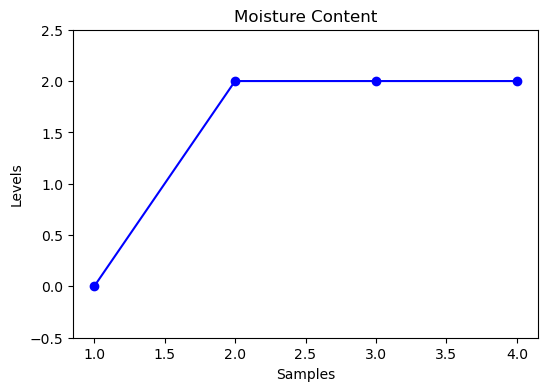

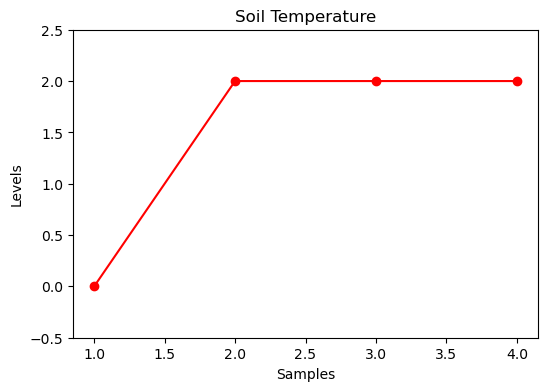

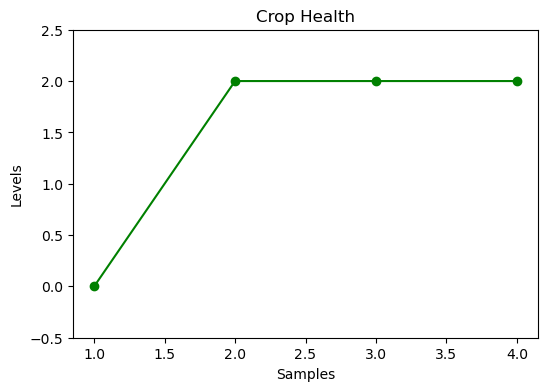

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# --- User Input ---
ndvi_val = float(input("Enter NDVI: "))
ndbi_val = float(input("Enter NDBI: "))
ndwi_val = float(input("Enter NDWI: "))
evi_val  = float(input("Enter EVI: "))
savi_val = float(input("Enter SAVI: "))
ndmi_val = float(input("Enter NDMI: "))

user_input = np.array([[ndvi_val, ndbi_val, ndwi_val, evi_val, savi_val, ndmi_val]])
user_input_scaled = scaler.transform(user_input)

# --- Predictions ---
moisture_pred = model_moisture.predict(user_input_scaled)[0]
soil_pred     = model_soil.predict(user_input_scaled)[0]
crop_pred     = model_crop.predict(user_input_scaled)[0]   

# --- Labels ---
moisture_labels = {0: "Low", 1: "Medium", 2: "High"}
soil_labels     = {0: "Low", 1: "Medium", 2: "High"}
crop_labels     = {0: "Low", 1: "Medium", 2: "High"}

alerts = {
    "Low":    "⚠ Alert: Critical low level detected!",
    "Medium": "ℹ Moderate condition, keep monitoring.",
    "High":   "✅ Optimal condition, all good!"
}

# --- Results ---
print(f"\nMoisture Level: {moisture_labels[moisture_pred]}")
print(alerts[moisture_labels[moisture_pred]])

soil_label = soil_labels[soil_pred]
print(f"\nSoil Temperature: {soil_label}")
print(alerts[soil_label])

if soil_pred == 2:
    print("⚠ ALERT: Soil overheating, risk of stress.")
elif soil_pred == 0:
    print("✅ Soil temperature is low and safe.")

crop_label = crop_labels[crop_pred]
print(f"\nCrop Health: {crop_label}")
print(alerts[crop_label])

if crop_pred == 0:
    print("🚨 ALERT: Crop health deteriorating, immediate action needed.")
elif crop_pred == 2:
    print("🌱 Crop health is good and stable.")

# ==========================
# --- PLOTTING SECTION ---
# ==========================

# Keep history lists across runs
try:
    moisture_history.append(moisture_pred)
    soil_history.append(soil_pred)
    crop_history.append(crop_pred)
except NameError:
    moisture_history, soil_history, crop_history = [moisture_pred], [soil_pred], [crop_pred]

# Limit to last 20 samples for clarity
samples = range(1, len(moisture_history[-20:]) + 1)

# --- Plot Moisture ---
plt.figure(figsize=(6,4))
plt.plot(samples, moisture_history[-20:], marker="o", color="blue")
plt.ylim(-0.5, 2.5)
plt.xlabel("Samples")
plt.ylabel("Levels")
plt.title("Moisture Content")
plt.show()

# --- Plot Soil Temperature ---
plt.figure(figsize=(6,4))
plt.plot(samples, soil_history[-20:], marker="o", color="red")
plt.ylim(-0.5, 2.5)
plt.xlabel("Samples")
plt.ylabel("Levels")
plt.title("Soil Temperature")
plt.show()

# --- Plot Crop Health ---
plt.figure(figsize=(6,4))
plt.plot(samples, crop_history[-20:], marker="o", color="green")
plt.ylim(-0.5, 2.5)
plt.xlabel("Samples")
plt.ylabel("Levels")
plt.title("Crop Health")
plt.show()
